In [1]:
# Imports

import numpy as np
import pandas as pd

from nltk import FreqDist
from nltk.corpus import stopwords
import spacy
import re
from collections import OrderedDict
import itertools
import string
import praw
from wordcloud import WordCloud, get_single_color_func
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 50

In [2]:
# 1000 top posts from washingtondc since as of 2/22/2024
df = pd.read_pickle('data/20240222_washingtondc_top_week_reddit_data.pkl')

In [3]:
df.head()

,submission,id,subreddit,title,url,selftext,is_self,post_hint,score,upvote_ratio,num_comments,comments,created_utc,datetime,date_retrieved,submission_age
0,1asgxq9,1asgxq9,washingtondc,The Perseverance rover’s 15.44-mile path had i...,https://i.redd.it/skb551ozwzic1.jpeg,,False,image,875,0.99,46,"(kqq9qm6, kqqao6r, kqqbhl3, kqq8fkj, kqqa5si, ...",1.708111e+09,2024-02-16 14:15:47,2024-02-22 11:58:50.359886,5 days 21:43:03.359886
1,1arm0hw,1arm0hw,washingtondc,Potomac Ave. METRO stop filled with smoke!,https://i.redd.it/zj9xeehuisic1.jpeg,,False,image,729,0.99,84,"(kqki15y, kqkesm1, kqkh9eo, kqkjvlz, kqkmp35, ...",1.708021e+09,2024-02-15 13:13:47,2024-02-22 11:58:50.359886,6 days 22:45:03.359886
2,1asn6nx,1asn6nx,washingtondc,Sharing some photos I made of politicians in w...,https://www.reddit.com/gallery/1asn6nx,,False,None,733,0.95,65,"(kqrku5d, kqsjgw1, kqrvv8s, kqs9cmq, kqrrdjb, ...",1.708127e+09,2024-02-16 18:36:22,2024-02-22 11:58:50.359886,5 days 17:22:28.359886
3,1awhcj6,1awhcj6,washingtondc,Looking for a mildly expensive awful restauran...,/r/newhampshire/comments/1auxoie/looking_for_a...,,False,None,618,0.92,701,"(krh8hhr, krhbx92, kri5ht3, krhda9a, krh54fe, ...",1.708535e+09,2024-02-21 12:08:54,2024-02-22 11:58:50.359886,0 days 23:49:56.359886
4,1arxvsn,1arxvsn,washingtondc,"Despite a tough few days for Metro, I apprecia...",https://www.reddit.com/gallery/1arxvsn,"This has been a tough week for Metro, but GM R...",False,None,612,0.98,37,"(kqmx9kp, kqn2qqk, kqn3acz, kqmx6ls, kqnckpa, ...",1.708052e+09,2024-02-15 21:45:54,2024-02-22 11:58:50.359886,6 days 14:12:56.359886


In [4]:
subreddit = df.iloc[0]['subreddit']
date_retrieved = df.iloc[0]['date_retrieved']
oldest = dt.datetime.strftime(df['datetime'].min(), "%m/%d/%Y")
newest = dt.datetime.strftime(df['datetime'].max(), "%m/%d/%Y")
date_retrieved = dt.datetime.strftime(date_retrieved, "%m/%d/%Y")
sort_filter = 'top_week'

print(subreddit)
print(sort_filter)
print(date_retrieved)
print(oldest)
print(newest)

washingtondc
top_week
02/22/2024
02/15/2024
02/22/2024


In [5]:
df['title'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 265 entries, 0 to 264
Series name: title
Non-Null Count  Dtype 
--------------  ----- 
265 non-null    object
dtypes: object(1)
memory usage: 2.2+ KB


In [6]:
df['selftext'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 265 entries, 0 to 264
Series name: selftext
Non-Null Count  Dtype 
--------------  ----- 
265 non-null    object
dtypes: object(1)
memory usage: 2.2+ KB


In [7]:
df['datetime'].describe()

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\476314687.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['datetime'].describe()


count                     265
unique                    265
top       2024-02-16 14:15:47
freq                        1
first     2024-02-15 11:18:59
last      2024-02-22 11:03:22
Name: datetime, dtype: object

In [8]:
df_nlp = df[['id', 'title', 'selftext', 'datetime']]

In [9]:
# Combine the title and body of the post

df_nlp['text_comb'] = df_nlp['title'] + '. ' + df_nlp['selftext']

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\4121555173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb'] = df_nlp['title'] + '. ' + df_nlp['selftext']


In [10]:
def clean_string(text):
    
    # Make everything lowercase
    cleaned = text.lower()

    # Remove excessive white space and newlines
    cleaned = cleaned.replace("\n", " ")
    cleaned = re.sub(pattern=r' {2,}', repl=' ', string=cleaned)

    # Ensure apostrophes and quotation marks are consistent
    cleaned = re.sub(r"’|‘", repl="'", string=cleaned)
    cleaned = re.sub(r"“|”", repl='"', string=cleaned)

    # Remove any difficult characters like emojis, elipses, etc. 
    cleaned = ''.join(filter(lambda x: x in string.printable, cleaned))
    
    return cleaned

In [11]:
df_nlp['text_comb'] = df_nlp['text_comb'].apply(clean_string)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\1584605208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb'] = df_nlp['text_comb'].apply(clean_string)


Why not remove punctuation in the cleaning step?

Removing punctuation is a common step in cleaning text for NLP. I don't do it here since I plan to lemmatize words which requires keeping grammatical context in the text. Punctuation will be removed in a future step.

In [12]:
# Setting up Spacy

nlp = spacy.load('en_core_web_sm')

In [13]:
# Combine Spacy and NLTK stop words to make them more comperehensive

sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
punct = list(string.punctuation)
stopword_list = list(set(sw_spacy + sw_nltk + punct))

## text_comb column

In [14]:
df_nlp['text_comb'].isna().sum()

0

In [15]:
# Making a Spacy object for each title

df_nlp['spacy_text_comb'] = df_nlp['text_comb'].apply(lambda x: nlp(clean_string(x)))

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\3001191996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['spacy_text_comb'] = df_nlp['text_comb'].apply(lambda x: nlp(clean_string(x)))


In [16]:
# df_nlp.sample()['title']

In [17]:
df_nlp['text_comb'].loc[81]

'majority of ward 7 ancs support streetcar extension. this week both anc 7d and anc 7b unanimously passed resolutions of support for the dc streetcar to benning road metro station. and two years ago in 2021 anc 7e passed a resolution of support as well. meaning that 3 out of the 5 ward 7 ancs have passed resolutions of support  including the most directly affected anc 7d. once extended anc 7d would contain more miles of streetcar than any anc in the city. additionally, the unanimity of the resolutions also means a majority of individual commissioners also support. and of course ward 7 councilmember vincent gray has been a life long champion. the chair of the ward 7 dems is also a strong supporter. so the community support is clearly there. and yet we have supposedly progressive councilmembers who talk a big game about listening to underserved communities and investing in underserved communities who actually voted to defund this project. why do we let cms use progressive rhetoric but th

In [18]:
# How Spacy's nlp object works:

sample_title = df_nlp['text_comb'].loc[81]

display('Spacy Object:')
display(nlp(sample_title))
print('Type:')
print(type(nlp(sample_title)))
print()
print('Tokens:')
print([t.text for t in list(nlp(sample_title))])
print()
print('Lemmas:')
print([t.lemma_ for t in list(nlp(sample_title))])
print()
print('Detect punctuation, numbers, etc.:')
print([t.is_punct for t in list(nlp(sample_title))])
print([t.is_digit for t in list(nlp(sample_title))])

'Spacy Object:'

majority of ward 7 ancs support streetcar extension. this week both anc 7d and anc 7b unanimously passed resolutions of support for the dc streetcar to benning road metro station. and two years ago in 2021 anc 7e passed a resolution of support as well. meaning that 3 out of the 5 ward 7 ancs have passed resolutions of support  including the most directly affected anc 7d. once extended anc 7d would contain more miles of streetcar than any anc in the city. additionally, the unanimity of the resolutions also means a majority of individual commissioners also support. and of course ward 7 councilmember vincent gray has been a life long champion. the chair of the ward 7 dems is also a strong supporter. so the community support is clearly there. and yet we have supposedly progressive councilmembers who talk a big game about listening to underserved communities and investing in underserved communities who actually voted to defund this project. why do we let cms use progressive rhetoric but the

Type:
<class 'spacy.tokens.doc.Doc'>

Tokens:
['majority', 'of', 'ward', '7', 'ancs', 'support', 'streetcar', 'extension', '.', 'this', 'week', 'both', 'anc', '7d', 'and', 'anc', '7b', 'unanimously', 'passed', 'resolutions', 'of', 'support', 'for', 'the', 'dc', 'streetcar', 'to', 'benning', 'road', 'metro', 'station', '.', 'and', 'two', 'years', 'ago', 'in', '2021', 'anc', '7e', 'passed', 'a', 'resolution', 'of', 'support', 'as', 'well', '.', 'meaning', 'that', '3', 'out', 'of', 'the', '5', 'ward', '7', 'ancs', 'have', 'passed', 'resolutions', 'of', 'support', ' ', 'including', 'the', 'most', 'directly', 'affected', 'anc', '7d', '.', 'once', 'extended', 'anc', '7d', 'would', 'contain', 'more', 'miles', 'of', 'streetcar', 'than', 'any', 'anc', 'in', 'the', 'city', '.', 'additionally', ',', 'the', 'unanimity', 'of', 'the', 'resolutions', 'also', 'means', 'a', 'majority', 'of', 'individual', 'commissioners', 'also', 'support', '.', 'and', 'of', 'course', 'ward', '7', 'councilmember', 'vin

In [19]:
df_nlp.head()

,id,title,selftext,datetime,text_comb,spacy_text_comb
0,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,,2024-02-16 14:15:47,the perseverance rover's 15.44-mile path had i...,"(the, perseverance, rover, 's, 15.44, -, mile,..."
1,1arm0hw,Potomac Ave. METRO stop filled with smoke!,,2024-02-15 13:13:47,potomac ave. metro stop filled with smoke!.,"(potomac, ave, ., metro, stop, filled, with, s..."
2,1asn6nx,Sharing some photos I made of politicians in w...,,2024-02-16 18:36:22,sharing some photos i made of politicians in w...,"(sharing, some, photos, i, made, of, politicia..."
3,1awhcj6,Looking for a mildly expensive awful restauran...,,2024-02-21 12:08:54,looking for a mildly expensive awful restauran...,"(looking, for, a, mildly, expensive, awful, re..."
4,1arxvsn,"Despite a tough few days for Metro, I apprecia...","This has been a tough week for Metro, but GM R...",2024-02-15 21:45:54,"despite a tough few days for metro, i apprecia...","(despite, a, tough, few, days, for, metro, ,, ..."


### Tokenizing

In [20]:
def spacy_tokenize(spacy_doc):
    """
    Takes in a Spacy doc and converts it to a list of tokens.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    tokens = [t.text for t in spacy_doc if token_mask(t)]
    return tokens

In [21]:
df_nlp['text_comb_tokens'] = df_nlp['spacy_text_comb'].apply(spacy_tokenize)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\4008261418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_tokens'] = df_nlp['spacy_text_comb'].apply(spacy_tokenize)


C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\2218918524.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


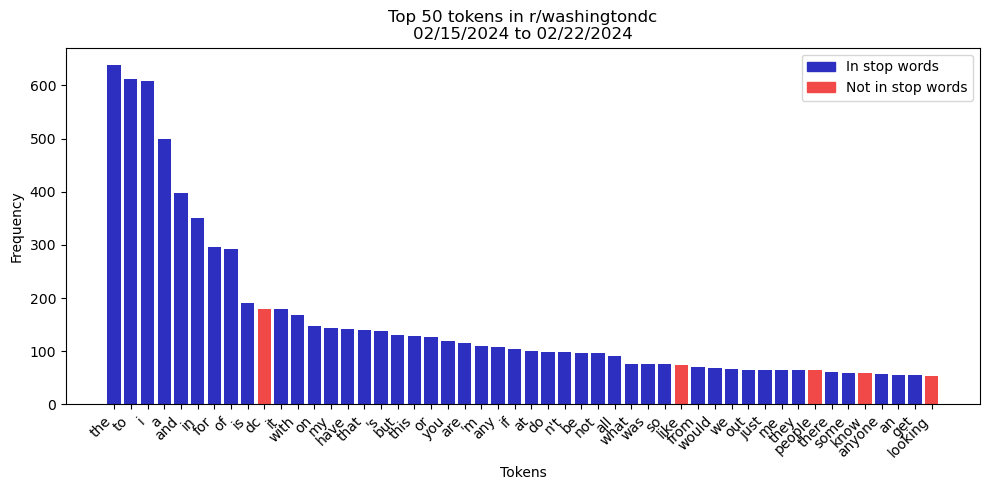

In [22]:
# Most frequent tokens. Stop words color-coded.

fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(df_nlp['text_comb_tokens'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
not_sw = [t for t in tokens if t not in stopword_list]
ax.bar(x=tokens, height=freq, color=['#f14848' if t in not_sw else '#2c2fbf' for t in tokens])
ax.set_ylabel('Frequency', size=10)
ax.set_xlabel('Tokens', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title(f'Top 50 tokens in r/{subreddit}\n{oldest} to {newest}')
custom_bars = [Rectangle((0,0),1,1,color=c, alpha=1) for c in ['#2c2fbf', '#f14848']]
ax.legend(custom_bars, ['In stop words','Not in stop words'], fontsize=10)
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_tokens2.png', dpi=500)
plt.show()

In [23]:
df_nlp['text_comb_tokens_no_sw'] = df_nlp['text_comb_tokens'].apply(lambda x: [t for t in x if t not in stopword_list])

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\797248638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_tokens_no_sw'] = df_nlp['text_comb_tokens'].apply(lambda x: [t for t in x if t not in stopword_list])


C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\4150107605.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


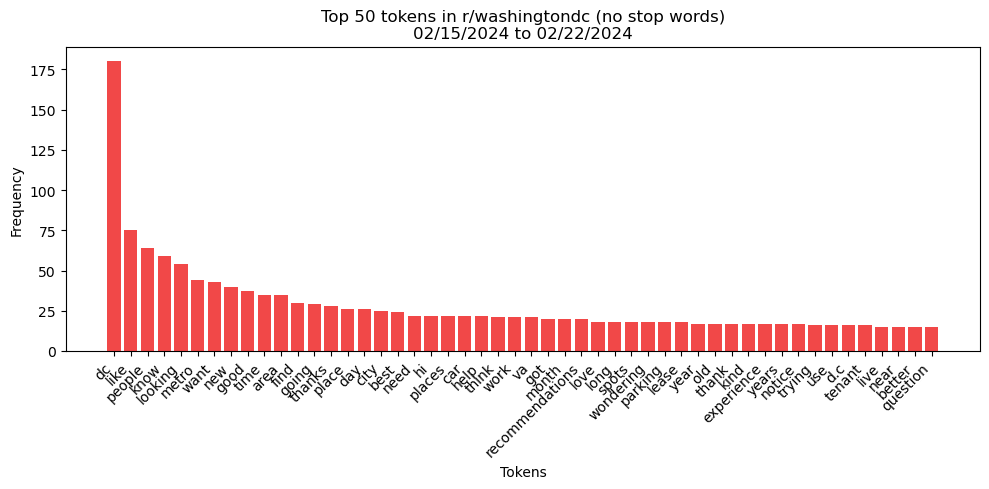

In [24]:
# Seeing most frequent tokens without stopwords:

fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(df_nlp[df_nlp['text_comb_tokens_no_sw'].apply(lambda x: len(x) > 0)]['text_comb_tokens_no_sw'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
ax.bar(x=tokens, height=freq, color='#f14848')
ax.set_xlabel('Tokens', size=10)
ax.set_ylabel('Frequency', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title(f'Top 50 tokens in r/{subreddit} (no stop words)\n{oldest} to {newest}')
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_tokens_no_sw2.png', dpi=500)
plt.show()

### Lemmas

In [25]:
def spacy_lemmatize(spacy_doc):
    """
    Takes in a Spacy doc and converts it to a list of lemmas.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    lemmas = [t.lemma_.lower() for t in spacy_doc if token_mask(t)]
    return lemmas

In [26]:
df_nlp['text_comb_lemmas'] = df_nlp['spacy_text_comb'].apply(spacy_lemmatize)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\1010819809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_lemmas'] = df_nlp['spacy_text_comb'].apply(spacy_lemmatize)


In [27]:
df_nlp.head()

,id,title,selftext,datetime,text_comb,spacy_text_comb,text_comb_tokens,text_comb_tokens_no_sw,text_comb_lemmas
0,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,,2024-02-16 14:15:47,the perseverance rover's 15.44-mile path had i...,"(the, perseverance, rover, 's, 15.44, -, mile,...","[the, perseverance, rover, 's, 15.44, mile, pa...","[perseverance, rover, 15.44, mile, path, lande...","[the, perseverance, rover, 's, 15.44, mile, pa..."
1,1arm0hw,Potomac Ave. METRO stop filled with smoke!,,2024-02-15 13:13:47,potomac ave. metro stop filled with smoke!.,"(potomac, ave, ., metro, stop, filled, with, s...","[potomac, ave, metro, stop, filled, with, smoke]","[potomac, ave, metro, stop, filled, smoke]","[potomac, ave, metro, stop, fill, with, smoke]"
2,1asn6nx,Sharing some photos I made of politicians in w...,,2024-02-16 18:36:22,sharing some photos i made of politicians in w...,"(sharing, some, photos, i, made, of, politicia...","[sharing, some, photos, i, made, of, politicia...","[sharing, photos, politicians, washington, pol...","[share, some, photo, i, make, of, politician, ..."
3,1awhcj6,Looking for a mildly expensive awful restauran...,,2024-02-21 12:08:54,looking for a mildly expensive awful restauran...,"(looking, for, a, mildly, expensive, awful, re...","[looking, for, a, mildly, expensive, awful, re...","[looking, mildly, expensive, awful, restaurant...","[look, for, a, mildly, expensive, awful, resta..."
4,1arxvsn,"Despite a tough few days for Metro, I apprecia...","This has been a tough week for Metro, but GM R...",2024-02-15 21:45:54,"despite a tough few days for metro, i apprecia...","(despite, a, tough, few, days, for, metro, ,, ...","[despite, a, tough, few, days, for, metro, i, ...","[despite, tough, days, metro, appreciate, gm, ...","[despite, a, tough, few, day, for, metro, i, a..."


In [28]:
# Check most common lemmas

FreqDist(df_nlp['text_comb_lemmas'].explode()).most_common(20)

[('be', 812),
 ('i', 673),
 ('the', 639),
 ('to', 616),
 ('a', 499),
 ('and', 398),
 ('in', 351),
 ('for', 297),
 ('of', 292),
 ('have', 236),
 ('not', 196),
 ('do', 187),
 ('dc', 180),
 ('it', 179),
 ('with', 169),
 ('on', 147),
 ('my', 144),
 ('that', 141),
 ('but', 131),
 ('this', 128)]

### Lemmas without stop words

In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because SpaCy uses grammatical context to lemmatize.

In [29]:
stopword_list_lem = []

sw_lem_Series = \
    df_nlp['spacy_text_comb'].apply(
        lambda x: [t.lemma_.lower() for t in x if t.text.lower() in stopword_list]
    )

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

In [30]:
# Lemmatized tokens, excluding stop words

df_nlp['text_comb_lemmas_no_sw'] = df_nlp['text_comb_lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\1486900218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_lemmas_no_sw'] = df_nlp['text_comb_lemmas'].apply(


In [31]:
df_nlp.head()

,id,title,selftext,datetime,text_comb,spacy_text_comb,text_comb_tokens,text_comb_tokens_no_sw,text_comb_lemmas,text_comb_lemmas_no_sw
0,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,,2024-02-16 14:15:47,the perseverance rover's 15.44-mile path had i...,"(the, perseverance, rover, 's, 15.44, -, mile,...","[the, perseverance, rover, 's, 15.44, mile, pa...","[perseverance, rover, 15.44, mile, path, lande...","[the, perseverance, rover, 's, 15.44, mile, pa...","[perseverance, rover, 15.44, mile, path, land,..."
1,1arm0hw,Potomac Ave. METRO stop filled with smoke!,,2024-02-15 13:13:47,potomac ave. metro stop filled with smoke!.,"(potomac, ave, ., metro, stop, filled, with, s...","[potomac, ave, metro, stop, filled, with, smoke]","[potomac, ave, metro, stop, filled, smoke]","[potomac, ave, metro, stop, fill, with, smoke]","[potomac, ave, metro, stop, fill, smoke]"
2,1asn6nx,Sharing some photos I made of politicians in w...,,2024-02-16 18:36:22,sharing some photos i made of politicians in w...,"(sharing, some, photos, i, made, of, politicia...","[sharing, some, photos, i, made, of, politicia...","[sharing, photos, politicians, washington, pol...","[share, some, photo, i, make, of, politician, ...","[share, photo, politician, washington, polaroi..."
3,1awhcj6,Looking for a mildly expensive awful restauran...,,2024-02-21 12:08:54,looking for a mildly expensive awful restauran...,"(looking, for, a, mildly, expensive, awful, re...","[looking, for, a, mildly, expensive, awful, re...","[looking, mildly, expensive, awful, restaurant...","[look, for, a, mildly, expensive, awful, resta...","[look, mildly, expensive, awful, restaurant, r..."
4,1arxvsn,"Despite a tough few days for Metro, I apprecia...","This has been a tough week for Metro, but GM R...",2024-02-15 21:45:54,"despite a tough few days for metro, i apprecia...","(despite, a, tough, few, days, for, metro, ,, ...","[despite, a, tough, few, days, for, metro, i, ...","[despite, tough, days, metro, appreciate, gm, ...","[despite, a, tough, few, day, for, metro, i, a...","[despite, tough, day, metro, appreciate, gm, c..."


## Seeing most frequent lemmas without stopwords:

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\2819685855.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


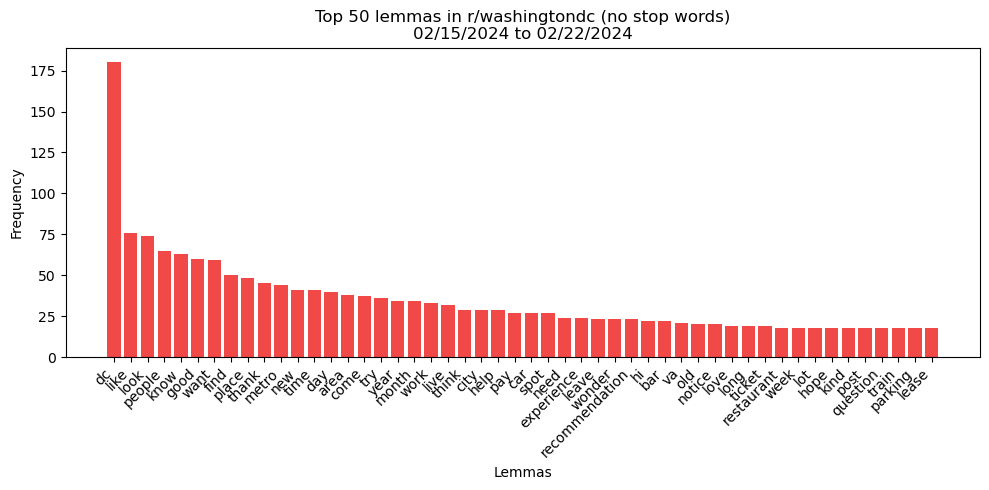

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_lem = OrderedDict(
    FreqDist(df_nlp[df_nlp['text_comb_lemmas_no_sw'].apply(lambda x: len(x) > 0)]['text_comb_lemmas_no_sw'].explode()).most_common(50)
    )

tokens = list(top_50_lem.keys())
freq = list(top_50_lem.values())
ax.bar(x=tokens, height=freq, color='#f14848')
ax.set_xlabel('Lemmas', size=10)
ax.set_ylabel('Frequency', size=10)
ax.set_title(f'Top 50 lemmas in r/{subreddit} (no stop words)\n{oldest} to {newest}')
ax.set_xticklabels(tokens, rotation=45, ha='right')
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_lemmas_no_sw2.png', dpi=500)
plt.show()

### Word Clouds

In [33]:
wc = WordCloud(
    # max_words=500, 
    # random_state=seed, 
    # font_path="./font/NotoSans-Regular.ttf", 
    colormap='Blues',
    # background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    background_color="black", mode="RGBA",
    width=1500,
    height=1000,
    )

In [34]:
fd_tokens = FreqDist(df_nlp['text_comb_tokens_no_sw'].explode())

In [35]:
fd_lemmas = FreqDist(df_nlp['text_comb_lemmas_no_sw'].explode())

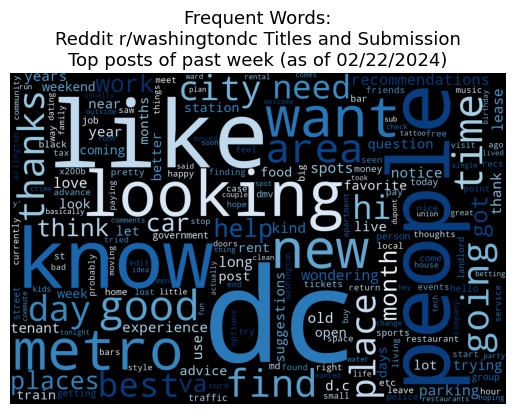

In [36]:
wc.generate_from_frequencies(fd_tokens)
plt.imshow(wc)
plt.axis("off")
plt.title(f'Frequent Words:\nReddit r/{subreddit} Titles and Submission\nTop posts of past week (as of {date_retrieved})', fontsize=13)
# plt.savefig('./images/word_cloud_tokens_text_comb2.png', dpi=500)
plt.show()

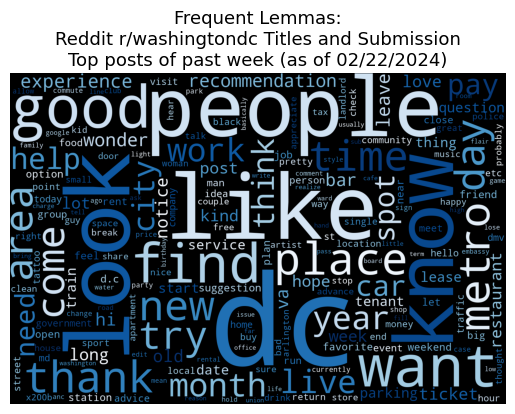

In [37]:
wc.generate_from_frequencies(fd_lemmas)
plt.imshow(wc)
plt.axis("off")
plt.title(f'Frequent Lemmas:\nReddit r/{subreddit} Titles and Submission\nTop posts of past week (as of {date_retrieved})', fontsize=13)
# plt.savefig('./images/word_cloud_lemmas_text_comb2.png', dpi=500)
plt.show()

## Comments

In [38]:
# Check if any comments aren't actually comments

for i in range(264):
    row = df.iloc[i]['comments']
    types = set([type(x) for x in row])
    if len(types) > 1:
        print(i)

3


In [39]:
# This "comment" is a "MoreComments" object. It contains more comments that can be called using x._comments

type(df.iloc[3]['comments'][-1])

praw.models.reddit.more.MoreComments

In [40]:
type(df.iloc[3]['comments'][-2])

praw.models.reddit.comment.Comment

There's probably a better way, but for now I'm just going to drop anything that's not a comment type.

In [41]:
# I can pull data like comment body and author name from the praw comment object.

display(df['comments'].apply(lambda x: [top_level_comment.body for top_level_comment in x if type(top_level_comment) == praw.models.reddit.comment.Comment]))

display(df['comments'].apply(lambda x: [top_level_comment.author for top_level_comment in x if type(top_level_comment) == praw.models.reddit.comment.Comment]))

# Lots of GIFs in these comments that I should remove

0      [Why didn’t it just take the metro? Is it stup...
1      [Just like the good old days. I have not seen ...
2      [It’s like I’m looking at an old family photo ...
3      [urban roast, Obviously Urban Roasts. Fuck the...
4      [This is how problems should be addressed... O...
                             ...                        
260    [There is not an extra $500m in the budget. Th...
261    [What’s the minimum salary that you would cons...
262    [No you only get shot for Canada Goose jackets...
263    [I've had consistently poor experiences with A...
264    [What does this have to do with DC?, Can we ju...
Name: comments, Length: 265, dtype: object

0      [No-Lunch4249, WeekendOkish, bad_lite, washing...
1      [Roubaix718, Bigtsez, mistersmiley318, DMClark...
2      [almondshea, carl164, Lanfrankenstein, Jealous...
3      [LocalBearEnthusiast, An_exasperated_couch, Fr...
4      [chkthetechnique, bad_lite, justalittleahead, ...
                             ...                        
260    [dcmcg, dangubiti, Nastronaut18, OkStruggle257...
261    [SuperBethesda, Arisen_Do_Urden, BoseSonic, De...
262    [GenitalPatton, The_Sauce_DC, purodirecto, sta...
263    [lh819, dangubiti, ko21361, Icy-Hope2634, djdd...
264    [Existing365Chocolate, Aklu_The_Unspeakable, L...
Name: comments, Length: 265, dtype: object

In [42]:
# New df. Exploding the comments so each comment is its own row.
# This is only showing top-level comments at this point

df_comments_nlp = df[['id', 'title', 'datetime', 'comments']]
df_comments_nlp['comments'] = df['comments'].apply(list)
df_comments_nlp = df_comments_nlp.explode('comments')
df_comments_nlp.columns = ['post_id', 'post_title', 'post_datetime', 'comment_object']
df_comments_nlp = df_comments_nlp.reset_index().drop(columns='index')
df_comments_nlp = df_comments_nlp[df_comments_nlp['comment_object'].apply(lambda x: type(x) == praw.models.reddit.comment.Comment)]
df_comments_nlp.head()

C:\Users\zshoo\AppData\Local\Temp\ipykernel_9280\341841520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_nlp['comments'] = df['comments'].apply(list)


,post_id,post_title,post_datetime,comment_object
0,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,2024-02-16 14:15:47,kqq9qm6
1,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,2024-02-16 14:15:47,kqqao6r
2,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,2024-02-16 14:15:47,kqqbhl3
3,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,2024-02-16 14:15:47,kqq8fkj
4,1asgxq9,The Perseverance rover’s 15.44-mile path had i...,2024-02-16 14:15:47,kqqa5si


In [43]:
df_comments_nlp['comment_object'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2971 entries, 0 to 2988
Series name: comment_object
Non-Null Count  Dtype 
--------------  ----- 
2971 non-null   object
dtypes: object(1)
memory usage: 46.4+ KB


In [44]:
df_comments_nlp.isna().sum()

post_id           0
post_title        0
post_datetime     0
comment_object    0
dtype: int64

In [45]:
df_comments_nlp = df_comments_nlp.dropna(subset=['comment_object'])

In [46]:
# New column for comment text

df_comments_nlp['comment'] = df_comments_nlp['comment_object'].apply(lambda x: x.body)

In [47]:
df_comments_nlp['comment'] = df_comments_nlp['comment'].apply(clean_string)

### Duplicates and useless comments

In [48]:
df_comments_nlp['comment'].value_counts()

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [49]:
# Drop deleted and removed comments

df_comments_nlp = df_comments_nlp[df_comments_nlp['comment'] != '[deleted]']
df_comments_nlp = df_comments_nlp[df_comments_nlp['comment'] != '[removed]']

In [50]:
# Drop comments that are gifs

df_comments_nlp = \
    df_comments_nlp[~df_comments_nlp['comment'].apply(lambda x: '![gif]' in x)]

In [51]:
# Drop blank and single character comments

df_comments_nlp = df_comments_nlp[~df_comments_nlp['comment'].apply(lambda x: len(x) in range(0,2))]

In [52]:
# Add a username column to aid in checking duplicates.

df_comments_nlp['user'] = df_comments_nlp['comment_object'].apply(lambda x: x.author.name if x.author else 'no_user')

In [53]:
# Drop posts by AutoModerator, which is a moderator bot

df_comments_nlp = df_comments_nlp[df_comments_nlp['user'] != 'AutoModerator']

In [54]:
# Some duplicate comments may remain, but they are not by the same user so I will view them as unique

display(df_comments_nlp[df_comments_nlp.duplicated(subset=['comment'])])

display(df_comments_nlp[df_comments_nlp.duplicated(subset=['comment', 'user'])])

,post_id,post_title,post_datetime,comment_object,comment,user
113,1awhcj6,Looking for a mildly expensive awful restauran...,2024-02-21 12:08:54,krhpzr5,urban roast,nowadultproblems
136,1awhcj6,Looking for a mildly expensive awful restauran...,2024-02-21 12:08:54,krht8q1,founding farmers,Cucumbrsandwich
141,1awhcj6,Looking for a mildly expensive awful restauran...,2024-02-21 12:08:54,krj0h0q,founding farmers,damnatio_memoriae
412,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr31iiu,following,AirbladeOrange
434,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr04v1q,interested!,AdOk1630
438,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr0dcet,following,Strange_Karma
441,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr0qt1a,interested,GunnyHighway88
442,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr0qwiy,following,Port46
443,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr0r1ub,following,Affectionate-Try-696
447,1atkba7,Singles in 30s / 40s - let's do a meetup! Any ...,2024-02-17 22:20:15,kr1v4rh,interested,Jolly-Age6280


,post_id,post_title,post_datetime,comment_object,comment,user


### Tokenizing Comments

In [55]:
# Spacy object of each comment